<a href="https://colab.research.google.com/github/virgiawan/yog2a-melanoma/blob/master/Melanoma_(Yusuf).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Melanoma Skin Cancer**

## 1. Preparation


In [0]:
!pip install kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"yusufmukti","key":"6fb203edd3d11b629bb80ca825c4f423"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d drscarlat/melanoma
!unzip -q melanoma.zip -d .
!ls

melanoma.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./DermMel/test/Melanoma/AUG_0_1001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  dermmel	   'kaggle API Token.json'   Melanoma.jpg
 DermMel	    kaggle.json		     melanoma.zip
'kaggle (1).json'  'Melanoma (1).jpg'	     sample_data


In [0]:
import os

base_dir = '/content/DermMel'

train_dir = os.path.join(base_dir, 'train_sep')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Label
melanoma = 'Melanoma'
not_melanoma = 'NotMelanoma'

# Train dataset directory
train_melanoma_dir = os.path.join(train_dir, melanoma)
train_not_melanoma_dir = os.path.join(train_dir, not_melanoma)

# Validation dataset directory
validation_melanoma_dir = os.path.join(validation_dir, melanoma)
validation_not_melanoma_dir = os.path.join(validation_dir, not_melanoma)

# Test dataset directory
test_melanoma_dir = os.path.join(test_dir, melanoma)
test_not_melanoma_dir = os.path.join(test_dir, not_melanoma)

In [0]:
train_melanoma_fnames = os.listdir(train_melanoma_dir)
train_not_melanoma_fnames = os.listdir(train_not_melanoma_dir)
total_train = len(os.listdir(train_melanoma_dir)) + len(os.listdir(train_not_melanoma_dir))
total_validation = len(os.listdir(validation_melanoma_dir)) + len(os.listdir(validation_not_melanoma_dir))
total_test = len(os.listdir(test_melanoma_dir)) + len(os.listdir(test_not_melanoma_dir))

print(train_melanoma_fnames[:10])
print(train_not_melanoma_fnames[:10])

['AUG_0_6240.jpeg', 'AUG_0_7776.jpeg', 'AUG_0_949.jpeg', 'ISIC_0025835.jpg', 'AUGmented_0_8857.jpeg', 'AUGmented_0_3125.jpeg', 'AUG_0_7634.jpeg', 'AUG_0_2133.jpeg', 'ISIC_0027776.jpg', 'AUG_0_6443.jpeg']
['ISIC_0030436.jpg', 'ISIC_0027119.jpg', 'ISIC_0032045.jpg', 'ISIC_0030409.jpg', 'ISIC_0031308.jpg', 'ISIC_0025368.jpg', 'ISIC_0029420.jpg', 'ISIC_0027097.jpg', 'ISIC_0026740.jpg', 'ISIC_0034182.jpg']


In [0]:
print('Total training melanoma images:', len(os.listdir(train_melanoma_dir)))
print('Total training not melanoma images:', len(os.listdir(train_not_melanoma_dir)))
print('Total training images:', total_train)
print()
print('Total validation melanoma images:', len(os.listdir(validation_melanoma_dir)))
print('Total validation not melanoma images:', len(os.listdir(validation_not_melanoma_dir)))
print('Total validation images:', total_validation)
print()
print('Total testing melanoma images:', len(os.listdir(test_melanoma_dir)))
print('Total testing not melanoma images:', len(os.listdir(test_not_melanoma_dir)))
print('Total testing images:', total_test)

Total training melanoma images: 5341
Total training not melanoma images: 5341
Total training images: 10682

Total validation melanoma images: 1781
Total validation not melanoma images: 1781
Total validation images: 3562

Total testing melanoma images: 1781
Total testing not melanoma images: 1780
Total testing images: 3561


In [0]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

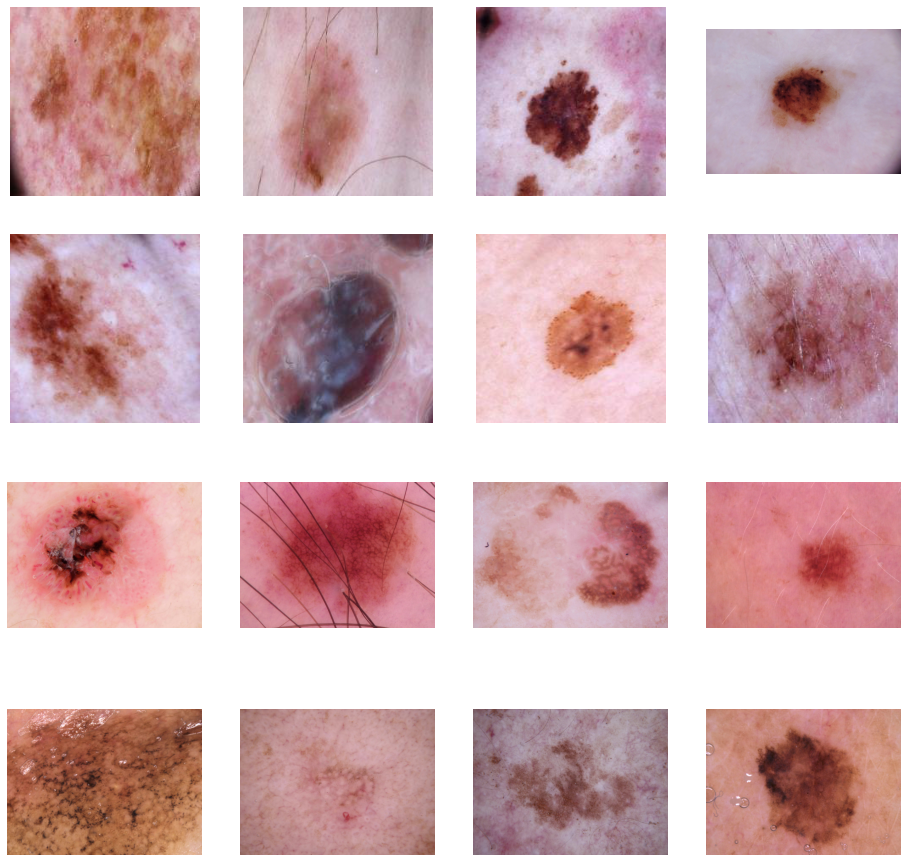

In [0]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_melanoma_pix = [os.path.join(train_melanoma_dir, fname) 
                for fname in train_melanoma_fnames[ pic_index-8:pic_index] 
               ]

next_not_melanoma_pix = [os.path.join(train_not_melanoma_dir, fname) 
                for fname in train_not_melanoma_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_melanoma_pix+next_not_melanoma_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [0]:
img = plt.imread(next_not_melanoma_pix[0])
img.shape

(450, 600, 3)

## 2. Model

### 2.1 Baseline

In [0]:
import tensorflow as tf

In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_195 (Conv2D)          (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_196 (Conv2D)          (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18496)            

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))
# Flow testing images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(150, 150))

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [0]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 65s - loss: 0.7326 - accuracy: 0.5630 - val_loss: 0.6280 - val_accuracy: 0.6310
Epoch 2/15
100/100 - 65s - loss: 0.6415 - accuracy: 0.6325 - val_loss: 0.5910 - val_accuracy: 0.6700
Epoch 3/15
100/100 - 65s - loss: 0.6100 - accuracy: 0.6725 - val_loss: 0.5153 - val_accuracy: 0.7270
Epoch 4/15
100/100 - 65s - loss: 0.5470 - accuracy: 0.7185 - val_loss: 0.5024 - val_accuracy: 0.7100
Epoch 5/15
100/100 - 65s - loss: 0.5157 - accuracy: 0.7410 - val_loss: 0.4674 - val_accuracy: 0.7430
Epoch 6/15
100/100 - 65s - loss: 0.5007 - accuracy: 0.7575 - val_loss: 0.4623 - val_accuracy: 0.7510
Epoch 7/15
100/100 - 65s - loss: 0.5238 - accuracy: 0.7520 - val_loss: 0.4241 - val_accuracy: 0.8030
Epoch 8/15
100/100 - 65s - loss: 0.4726 - accuracy: 0.7775 - val_loss: 0.3902 - val_accuracy: 0.8490
Epoch 9/15
100/100 - 64s - loss: 0.4981 - accuracy: 0.8005 - val_loss: 0.4576 - val_accuracy: 0.7910
Epoch 10/15
100/100 - 64s - loss: 0.4201 - accuracy: 0.8290 - val_loss: 0.8007 - val_accura

In [79]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is not a melanoma")
    
  else:
    print(fn + " is a melanoma")

Saving Melanoma.jpg to Melanoma (2).jpg
[0.]
Melanoma.jpg is a melanoma


In [80]:
model.evaluate(test_generator)

179/179 [==============================] - 48s 266ms/step - loss: 0.4008 - accuracy: 0.8253


[0.40080365538597107, 0.8253299593925476]

Text(0.5, 1.0, 'Training and validation loss')

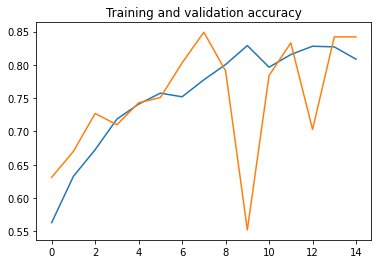

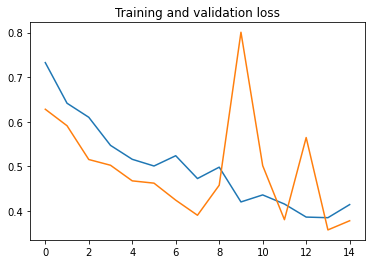

In [81]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

### 2.2 Augmentation

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [99]:
# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
# Flow testing images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(150, 150))

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [0]:
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [0]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [0]:
# callbacks = myCallback()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [88]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_steps=50,
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/100
100/100 - 121s - loss: 0.6667 - accuracy: 0.5810 - val_loss: 0.6226 - val_accuracy: 0.6730
Epoch 2/100
100/100 - 121s - loss: 0.6094 - accuracy: 0.6530 - val_loss: 0.5673 - val_accuracy: 0.6870
Epoch 3/100
100/100 - 121s - loss: 0.5830 - accuracy: 0.6745 - val_loss: 0.6228 - val_accuracy: 0.6280
Epoch 4/100
100/100 - 124s - loss: 0.5562 - accuracy: 0.6855 - val_loss: 0.5158 - val_accuracy: 0.7020
Epoch 5/100
100/100 - 122s - loss: 0.5521 - accuracy: 0.7050 - val_loss: 0.5013 - val_accuracy: 0.7120
Epoch 6/100
100/100 - 120s - loss: 0.5345 - accuracy: 0.7195 - val_loss: 0.5318 - val_accuracy: 0.6920
Epoch 7/100
100/100 - 121s - loss: 0.5325 - accuracy: 0.7205 - val_loss: 0.4940 - val_accuracy: 0.7680
Epoch 8/100
100/100 - 120s - loss: 0.5227 - accuracy: 0.7345 - val_loss: 0.4790 - val_accuracy: 0.7670
Epoch 9/100
100/100 - 120s - loss: 0.5125 - accuracy: 0.7376 - val_loss: 0.4565 - val_accuracy: 0.7730
Epoch 10/100
100/100 - 119s - loss: 0.5060 - accuracy: 0.7457 - val_loss:

In [89]:
model.evaluate(test_generator)

179/179 [==============================] - 61s 340ms/step - loss: 0.3920 - accuracy: 0.8113


[0.3919910788536072, 0.8112889528274536]

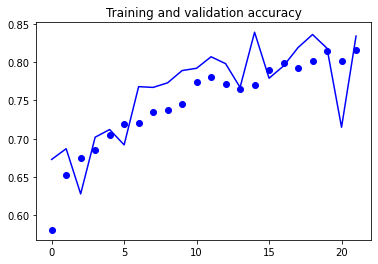

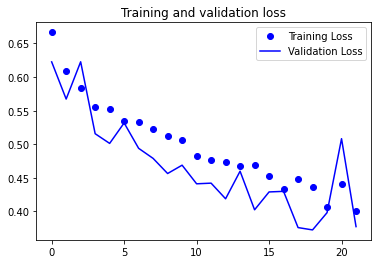

In [90]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 2.3 Pre-Trained

In [91]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-06-03 13:03:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  90.1MB/s    in 0.9s    

2020-06-03 13:03:41 (90.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [93]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))
# Flow testing images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(150, 150))

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [94]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 159s - loss: 0.6203 - accuracy: 0.7295 - val_loss: 0.3596 - val_accuracy: 0.8470
Epoch 2/20
100/100 - 158s - loss: 0.4567 - accuracy: 0.7950 - val_loss: 0.3444 - val_accuracy: 0.8430
Epoch 3/20
100/100 - 159s - loss: 0.4333 - accuracy: 0.8075 - val_loss: 0.4579 - val_accuracy: 0.7860
Epoch 4/20
100/100 - 159s - loss: 0.4073 - accuracy: 0.8269 - val_loss: 0.3120 - val_accuracy: 0.8680
Epoch 5/20
100/100 - 158s - loss: 0.3829 - accuracy: 0.8345 - val_loss: 0.2860 - val_accuracy: 0.8900
Epoch 6/20
100/100 - 158s - loss: 0.3750 - accuracy: 0.8400 - val_loss: 0.2817 - val_accuracy: 0.8890
Epoch 7/20
100/100 - 159s - loss: 0.3808 - accuracy: 0.8410 - val_loss: 0.2568 - val_accuracy: 0.8810
Epoch 8/20
100/100 - 160s - loss: 0.3621 - accuracy: 0.8505 - val_loss: 0.3024 - val_accuracy: 0.8870
Epoch 9/20
100/100 - 161s - loss: 0.3356 - accuracy: 0.8615 - val_loss: 0.2882 - val_accuracy: 0.8840
Epoch 10/20
100/100 - 158s - loss: 0.3400 - accuracy: 0.8645 - val_loss: 0.2587 - 

In [95]:
model.evaluate(test_generator)

179/179 [==============================] - 147s 822ms/step - loss: 0.3947 - accuracy: 0.8526


[0.3947097063064575, 0.8525695204734802]

Text(0.5, 1.0, 'Training and validation loss')

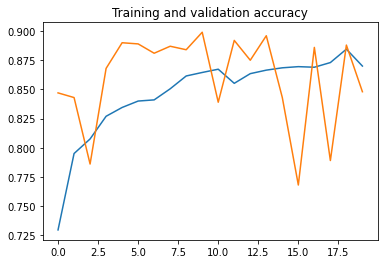

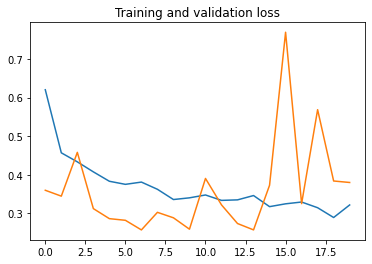

In [103]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )